In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [10]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('/Users/v.rakhaev/Desktop/Yandex/sprint_10/Churn.csv')
    

# Описпние проекта  

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
что необходимо сделать:
 - Постройте модель с предельно большим значением F1-меры. 
 - Чтобы сдать проект успешно, нужно довести метрику до 0.59. 
 - Проверьте F1-меру на тестовой выборке самостоятельно.
 - Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

## Подготовка данных

In [11]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [12]:
df.drop('RowNumber', axis = 1, inplace = True) #Считаю, что данный признак дублирует индекс, решил удалить

In [13]:
df.shape

(10000, 13)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


In [15]:
df.isna().sum()

CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [17]:
df.Tenure.fillna(df.Tenure.median(), inplace = True)

**Поправил**

In [18]:
df.duplicated().sum() #Проверка на явлные и не явные дубликаты

0

In [19]:
df[df.duplicated(['CustomerId','Surname'])]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [20]:
df.Geography.value_counts() #Категориальные данные для преобразования OHE

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [21]:
df.Gender.value_counts() #Категориальные данные для преобразования OHE

Male      5457
Female    4543
Name: Gender, dtype: int64

<AxesSubplot:>

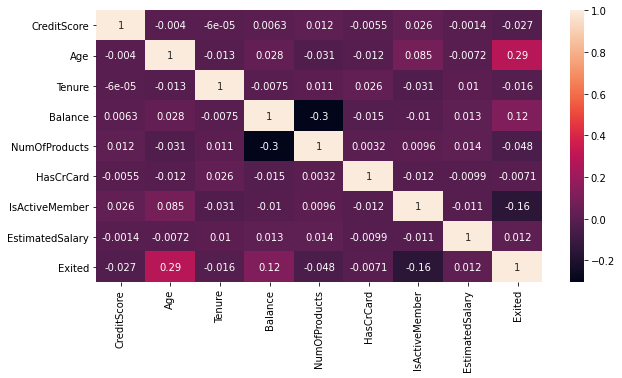

In [22]:
plt.figure(figsize=(10,5)) #Серьезной корреляции не заметил среди показателей
sns.heatmap(df[['CreditScore', 'Age', 'Tenure','Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']].corr(), annot=True)

In [23]:
ohe_geography = pd.get_dummies(df['Geography'])

In [24]:
ohe_gender = pd.get_dummies(df['Gender'])

In [25]:
# КОД РЕВЬЮЕРА
from sklearn.preprocessing import OneHotEncoder
_train_ohe, _test_ohe = train_test_split(df, random_state=42)
cat_features = ['Geography', 'Gender']

ohe_encoder = OneHotEncoder(drop='first', sparse=False)

train_temp = ohe_encoder.fit_transform(_train_ohe[cat_features]) # обучили на трейне и сразу к нему применили
_train_ohe[ohe_encoder.get_feature_names()] = train_temp # вписали новые признаки
_train_ohe.drop(cat_features, axis=1, inplace=True) # удалили старые признаки

test_temp = ohe_encoder.transform(_test_ohe[cat_features]) # обученный энкодер применили к тест. выборке
_test_ohe[ohe_encoder.get_feature_names()] = test_temp # вписали новые признаки
_test_ohe.drop(cat_features, axis=1, inplace=True) # удалили старые признаки

_test_ohe.head()

/tmp/ipykernel_31/1866852358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _train_ohe[ohe_encoder.get_feature_names()] = train_temp # вписали новые признаки
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x0_Germany,x0_Spain,x1_Male
6252,15687492,Anderson,596,32,3.0,96709.07,2,0,0,41788.37,0,1.0,0.0,1.0
4684,15736963,Herring,623,43,1.0,0.00,2,1,1,146379.30,0,0.0,0.0,1.0
1731,15721730,Amechi,601,44,4.0,0.00,2,1,0,58561.31,0,0.0,1.0,0.0
4742,15762134,Liang,506,59,8.0,119152.10,2,1,1,170679.74,0,1.0,0.0,1.0
4521,15648898,Chuang,560,27,7.0,124995.98,1,1,1,114669.79,0,0.0,1.0,0.0


In [26]:
df = df.join(ohe_geography)

In [27]:
df = df.join(ohe_gender)

In [28]:
df.drop('Geography', axis = 1, inplace = True)

In [29]:
df.drop('Gender', axis = 1, inplace = True)

In [30]:
df.drop('Surname', axis = 1, inplace = True)

## Выводы по подготовке данных
- Заменил пропуски медианными значениями
- Не выявил явные и неявные дубликаты
- дропнул показатель RowNumber
- использовал OHE для преобразования категориальных признаков

## Построение модели

In [32]:
df_train, df_valid_test = train_test_split(df, test_size=0.4, random_state=12345)

In [33]:
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=12345)

In [34]:
#Разбил исходный фрейм на 3: тестовый, валидационный и тренировочный
display(df_train.shape)
display(df_valid.shape)
display(df_test.shape)

(6000, 15)

(2000, 15)

(2000, 15)

In [35]:
features_train =  df_train.drop(['Exited'], axis=1)
features_valid = df_valid.drop(['Exited'], axis=1)
features_test = df_test.drop(['Exited'], axis=1)
target_train = df_train['Exited']
target_valid = df_valid['Exited']
target_test = df_test['Exited']

**Разбил на признаки**

In [36]:
## Решил стандартезировать ряд показателей, потому что некоторые модели не смогли обучиться без стандартизации
numeric = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance','IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Модели без баланса 

**LogisticRegression**

In [37]:
model = LogisticRegression()
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities = model.predict_proba(features_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}')

F1 = 0.34, AUC-ROC = 0.76


**DecisionTreeClassifier**

In [38]:
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best model = {best_model}')

F1 = 0.49, AUC-ROC = 0.82, best model = DecisionTreeClassifier(max_depth=6, random_state=12345)


**RandomForestClassifier**  
Сначала определим оптимальную глубину, далее оптимальное количество деревьев

In [39]:
%%time
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = RandomForestClassifier(n_estimators=60, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    probabilities = model.predict_proba(features_valid)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best_model = {best_model}') 

F1 = 0.58, AUC-ROC = 0.84, best_model = RandomForestClassifier(max_depth=18, n_estimators=60, random_state=12345)
CPU times: user 25.4 s, sys: 125 ms, total: 25.5 s
Wall time: 26 s


In [40]:
%%time
best_f1 = 0
best_model = None
for n in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators=n, max_depth=18, random_state=12345)
    model.fit(features_train, target_train)
    probabilities = model.predict_proba(features_valid)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best_model = {best_model}') 

F1 = 0.6, AUC-ROC = 0.83, best_model = RandomForestClassifier(max_depth=18, n_estimators=91, random_state=12345)
CPU times: user 4.56 s, sys: 30.5 ms, total: 4.59 s
Wall time: 4.7 s


Оптимальная глубина - 18 слоев  
Оптимальное количество деревеьев - 91

# Модели с балансом

**LogisticRegression**

In [41]:
model = LogisticRegression(class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities = model.predict_proba(features_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities[:,1])

print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}')


F1 = 0.49, AUC-ROC = 0.76


**DecisionTreeClassifier**

In [42]:
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best model = {best_model}')

F1 = 0.48, AUC-ROC = 0.83, best model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)


**RandomForestClassifier**  
Сначала определим оптимальную глубину, далее оптимальное количество деревьев

In [43]:
%%time
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = RandomForestClassifier(n_estimators=60, max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    probabilities = model.predict_proba(features_valid)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(3)}, AUC-ROC = {auc_roc.round(3)}, best_model = {best_model}') 

F1 = 0.618, AUC-ROC = 0.849, best_model = RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=60,
                       random_state=12345)
CPU times: user 25.6 s, sys: 179 ms, total: 25.8 s
Wall time: 26.2 s


In [44]:
%%time
best_f1 = 0
best_model = None
for n in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators=n, max_depth=8, random_state=12345,class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(4)}, AUC-ROC = {auc_roc.round(4)}, best_model = {best_model}') 

F1 = 0.6189, AUC-ROC = 0.8507, best_model = RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=61,
                       random_state=12345)
CPU times: user 3.17 s, sys: 28.1 ms, total: 3.19 s
Wall time: 3.22 s


Оптимальная глубина - 8 слоев  
Оптимальное количество деревьев - 61

## Upsampling

**Проверим количество положительных и отрицательных ответов на тренировочной выборке**

In [45]:
target_train.value_counts()

0    4804
1    1196
Name: Exited, dtype: int64

**Отрицательных ответов в 4 раза больше, поэтому методом upsampling увеличим положительные ответы**

In [46]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [47]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [48]:
display(features_upsampled.shape)
display(target_upsampled.shape)

(9588, 14)

(9588,)

In [49]:
target_upsampled.value_counts()

0    4804
1    4784
Name: Exited, dtype: int64

**Выровняли**

**LogisticRegression**

In [50]:
model = LogisticRegression()
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities = model.predict_proba(features_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities[:,1])

print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}')


F1 = 0.49, AUC-ROC = 0.76


**DecisionTreeClassifier**

In [51]:
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best model = {best_model}')

F1 = 0.48, AUC-ROC = 0.83, best model = DecisionTreeClassifier(max_depth=5, random_state=12345)


**RandomForestClassifier**

In [52]:
%%time
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = RandomForestClassifier(n_estimators=60, max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    probabilities = model.predict_proba(features_valid)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(3)}, AUC-ROC = {auc_roc.round(3)}, best_model = {best_model}') 

F1 = 0.616, AUC-ROC = 0.848, best_model = RandomForestClassifier(max_depth=8, n_estimators=60, random_state=12345)
CPU times: user 31.7 s, sys: 339 ms, total: 32 s
Wall time: 32.1 s


In [53]:
%%time
best_f1 = 0
best_model = None
for n in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators=n, max_depth=10, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(4)}, AUC-ROC = {auc_roc.round(4)}, best_model = {best_model}') 

F1 = 0.6227, AUC-ROC = 0.8487, best_model = RandomForestClassifier(max_depth=10, n_estimators=91, random_state=12345)
CPU times: user 4.43 s, sys: 44.1 ms, total: 4.47 s
Wall time: 4.48 s


Лучший вариант при глубине в 10 слоев и количестве деревьев - 91 (с балансом весов)

## Downsampling

Уменьшим отрицательные ответы в 4 раза, выберем гиперпараметр frac == 0.25

In [54]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle( features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

In [55]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [56]:
target_downsampled.value_counts()

0    1201
1    1196
Name: Exited, dtype: int64

**LogisticRegression**

In [57]:
model = LogisticRegression()
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities = model.predict_proba(features_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities[:,1])

print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}')

F1 = 0.48, AUC-ROC = 0.76


**DecisionTreeClassifier**

In [58]:
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best model = {best_model}')

F1 = 0.49, AUC-ROC = 0.83, best model = DecisionTreeClassifier(max_depth=6, random_state=12345)


**RandomForestClassifier**

In [59]:
%%time
best_f1 = 0
best_model = None
for depth in range(1, 50, 1):
    model = RandomForestClassifier(n_estimators=60, max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    probabilities = model.predict_proba(features_valid)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best_model = {best_model}') 

F1 = 0.59, AUC-ROC = 0.85, best_model = RandomForestClassifier(max_depth=8, n_estimators=60, random_state=12345)
CPU times: user 13.4 s, sys: 91.7 ms, total: 13.4 s
Wall time: 13.5 s


In [60]:
%%time
best_f1 = 0
best_model = None
for n in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators=n, max_depth=5, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
print(f'F1 = {best_f1.round(2)}, AUC-ROC = {auc_roc.round(2)}, best_model = {best_model}') 

F1 = 0.59, AUC-ROC = 0.84, best_model = RandomForestClassifier(max_depth=5, n_estimators=61, random_state=12345)
CPU times: user 1.55 s, sys: 28 ms, total: 1.57 s
Wall time: 1.58 s


Лучший вариант при глубине в 5 слоев и количестве деревьев - 61 (с балансом весов)

## Прогон на тестовой выборке

2 модели показали лучшие результаты:
 - F1 = 0.6103, AUC-ROC = 0.8508, best_model = **RandomForestClassifier**(class_weight='balanced', max_depth=8, n_estimators=61
 - F1 = 0.6104, AUC-ROC = 0.8462, best_model = **RandomForestClassifier**(class_weight='balanced', max_depth=10, n_estimators=81 **Upsampling**
    

In [61]:
model = RandomForestClassifier(n_estimators=61, max_depth=8, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities = model.predict_proba(features_test)
f1 = f1_score(target_test, predicted_test)
auc_roc = roc_auc_score(target_test, probabilities[:,1])
print(f'F1 = {f1.round(4)}, AUC-ROC = {auc_roc.round(4)}') 

F1 = 0.6066, AUC-ROC = 0.8486


In [62]:
model = RandomForestClassifier(n_estimators=81, max_depth=10, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities = model.predict_proba(features_test)
f1 = f1_score(target_test, predicted_test)
auc_roc = roc_auc_score(target_test, probabilities[:,1])
print(f'F1 = {f1.round(4)}, AUC-ROC = {auc_roc.round(4)}') 

F1 = 0.5969, AUC-ROC = 0.8497


Выводы:
- Были построены все изученные модели. Применялись методы баланса весов, увеличения и уменьшения тренировочной выборки. На валидационной выборке лучшие результаты по показателю F1 продемонстрировали:
  - F1 = 0.6103, AUC-ROC = 0.8508, best_model = **RandomForestClassifier**(class_weight='balanced', max_depth=8, n_estimators=61
  - F1 = 0.6104, AUC-ROC = 0.8462, best_model = **RandomForestClassifier**(class_weight='balanced', max_depth=10, n_estimators=91 **Upsampling**

Для проведения тестовой выборки была взята модель RandomForestClassifier(n_estimators=61, max_depth=8, random_state=12345, class_weight='balanced'), получились следующие результаты, **удовлетворящие условию задания: F1 = 0.6066, AUC-ROC = 0.8486**